<a href="https://colab.research.google.com/github/Poojitha12345678/Object_Detection_BCCD_Yolo10/blob/main/BCCD_YOLO_Assignemnt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Clone the Dataset
!git clone 'https://github.com/Shenggan/BCCD_Dataset.git'

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800 (from 1)
Receiving objects: 100% (800/800), 7.39 MiB | 18.05 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [2]:
# Install Dependencies
!pip install ultralytics
!pip install opencv-python numpy torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
#Preprocessing the Data , split the train , test , validate data
import os
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

def convert_annotation(image_id, input_dir, output_dir, class_names):
    """Converts Pascal VOC annotation to YOLO format."""
    in_file = open(os.path.join(input_dir, f'{image_id}.xml'))
    out_file = open(os.path.join(output_dir, f'{image_id}.txt'), 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.findall('object'):
        cls = obj.find('name').text
        if cls not in class_names:
            continue
        cls_id = class_names.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
             float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w, h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

def convert(size, box):
    """Converts bounding box coordinates to YOLO format."""
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return x, y, w, h

def main(image_dir, annotation_dir, output_dir, class_names):
    """Converts annotations and splits dataset into train, validation, and test sets."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_ids = [os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith('.jpg')]

    train_ids, temp_ids = train_test_split(image_ids, test_size=0.3, random_state=42)
    val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

    sets = [('train', train_ids), ('valid', val_ids), ('test', test_ids)]

    for set_name, image_ids in sets:
        set_dir = os.path.join(output_dir, set_name)
        if not os.path.exists(set_dir):
            os.makedirs(set_dir)

        image_set_dir = os.path.join(output_dir, set_name, 'images')
        label_set_dir = os.path.join(output_dir, set_name, 'labels')
        if not os.path.exists(image_set_dir):
            os.makedirs(image_set_dir)
        if not os.path.exists(label_set_dir):
            os.makedirs(label_set_dir)

        for image_id in image_ids:
            # Copy images to train/valid/test directories
            os.system(f'cp {os.path.join(image_dir, image_id + ".jpg")} {os.path.join(image_set_dir, image_id + ".jpg")}')
            # Convert annotations
            convert_annotation(image_id, annotation_dir, label_set_dir, class_names)

if __name__ == "__main__":
    image_dir = '/content/BCCD_Dataset/BCCD/JPEGImages'
    annotation_dir = '/content/BCCD_Dataset/BCCD/Annotations'
    output_dir = '/content/BCCD_Dataset/BCCD/yolo_dataset'
    class_names = ['RBC', 'WBC', 'Platelets']

    main(image_dir, annotation_dir, output_dir, class_names)

In [4]:
#import YOLO
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
#Build model
model = YOLO("yolov10n.pt")  # Load pre-trained YOLOv10 nano model
model.train(data="dataset.yaml", epochs=50, batch=8, imgsz=640)

100%|██████████| 5.59M/5.59M [00:00<00:00, 15.6MB/s]


Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=dataset.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

100%|██████████| 755k/755k [00:00<00:00, 3.21MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 12.7MB/s]


AMP: checks passed ✅


train: Scanning /content/BCCD_Dataset/BCCD/yolo_dataset/train/labels... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<00:00, 2220.66it/s]

train: New cache created: /content/BCCD_Dataset/BCCD/yolo_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/BCCD_Dataset/BCCD/yolo_dataset/valid/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 1389.25it/s]

val: New cache created: /content/BCCD_Dataset/BCCD/yolo_dataset/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.66G      2.546      6.372      2.642        142        640: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all         55        774      0.022      0.641      0.219      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.82G      2.532      4.079      2.411        115        640: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.53it/s]

                   all         55        774      0.634       0.48      0.404      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.84G      2.506      3.216       2.42        133        640: 100%|██████████| 32/32 [00:06<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all         55        774      0.753      0.404      0.469      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.85G      2.453       3.01       2.43        155        640: 100%|██████████| 32/32 [00:06<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.70it/s]


                   all         55        774      0.704      0.499      0.708      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.87G      2.387      2.695      2.386        157        640: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.83it/s]

                   all         55        774      0.548      0.708      0.694      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.88G      2.354      2.568      2.399        112        640: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]

                   all         55        774      0.676       0.73      0.748      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       1.9G      2.313      2.455      2.336        152        640: 100%|██████████| 32/32 [00:06<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]

                   all         55        774      0.719      0.772      0.789      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.91G      2.364      2.409      2.372        131        640: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.54it/s]

                   all         55        774      0.673      0.812      0.807      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.93G      2.265      2.285      2.322        155        640: 100%|██████████| 32/32 [00:05<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.92it/s]


                   all         55        774      0.726      0.747      0.813      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.95G       2.26      2.228      2.308        160        640: 100%|██████████| 32/32 [00:06<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.52it/s]

                   all         55        774      0.648      0.796      0.818      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.96G      2.215      2.129      2.288        197        640: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all         55        774      0.734      0.837      0.833      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.98G       2.26      2.188      2.303        119        640: 100%|██████████| 32/32 [00:06<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.82it/s]


                   all         55        774      0.753      0.746      0.829      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.99G      2.169      2.067      2.267        200        640: 100%|██████████| 32/32 [00:06<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]

                   all         55        774      0.733      0.727      0.824      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.08G      2.244      2.052      2.286        198        640: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.84it/s]

                   all         55        774      0.724      0.796      0.835      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.1G      2.214      2.019      2.278        123        640: 100%|██████████| 32/32 [00:06<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.87it/s]

                   all         55        774       0.73      0.792      0.849      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.11G      2.166      1.976      2.292         89        640: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.47it/s]

                   all         55        774       0.77      0.873      0.878      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.13G      2.231      1.983      2.301         89        640: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.65it/s]

                   all         55        774       0.76      0.853       0.86      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.14G      2.235      1.979      2.273        134        640: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.94it/s]

                   all         55        774      0.733      0.822      0.848      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.16G      2.161      1.921      2.292        100        640: 100%|██████████| 32/32 [00:06<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.74it/s]

                   all         55        774       0.79       0.84      0.875      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.18G      2.156      1.855      2.255        134        640: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.72it/s]


                   all         55        774      0.788      0.879      0.883      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.19G      2.193      1.874      2.342         94        640: 100%|██████████| 32/32 [00:06<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.01it/s]

                   all         55        774      0.821       0.86      0.896      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.21G      2.126      1.771      2.244        151        640: 100%|██████████| 32/32 [00:06<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]

                   all         55        774      0.751       0.85      0.879      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       2.3G      2.204      1.835      2.331        156        640: 100%|██████████| 32/32 [00:05<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.01it/s]


                   all         55        774      0.768      0.849      0.877      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.32G      2.131      1.722      2.262         95        640: 100%|██████████| 32/32 [00:06<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.74it/s]

                   all         55        774      0.844      0.828      0.892      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.33G      2.147      1.741      2.294        107        640: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.55it/s]


                   all         55        774      0.857      0.816      0.896      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.35G      2.103      1.692      2.213        148        640: 100%|██████████| 32/32 [00:06<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.58it/s]


                   all         55        774       0.82      0.844      0.897      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.37G       2.11      1.715      2.273        210        640: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.17it/s]


                   all         55        774      0.862       0.82      0.903      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.38G      2.068      1.676      2.193        111        640: 100%|██████████| 32/32 [00:06<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.76it/s]

                   all         55        774      0.823      0.833      0.879      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.4G      2.127      1.653      2.237         90        640: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.79it/s]


                   all         55        774      0.802       0.84      0.879      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.41G       2.08       1.63      2.241        105        640: 100%|██████████| 32/32 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.32it/s]

                   all         55        774      0.745      0.887      0.881       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.43G       2.07      1.618      2.232        165        640: 100%|██████████| 32/32 [00:06<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

                   all         55        774      0.823      0.848      0.895      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.44G      2.035      1.575      2.196        114        640: 100%|██████████| 32/32 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.28it/s]

                   all         55        774      0.816      0.892      0.908      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.46G       2.04      1.604      2.224        110        640: 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.37it/s]

                   all         55        774      0.815      0.896      0.895      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.47G      2.062      1.583      2.209        164        640: 100%|██████████| 32/32 [00:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.75it/s]

                   all         55        774      0.804       0.88      0.894      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.49G      2.051      1.589      2.216        121        640: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.81it/s]

                   all         55        774      0.819      0.861      0.908      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.5G       2.06      1.558      2.211        198        640: 100%|██████████| 32/32 [00:05<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]

                   all         55        774      0.827      0.877      0.907      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.52G      1.996      1.515       2.18        154        640: 100%|██████████| 32/32 [00:06<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.72it/s]

                   all         55        774        0.8      0.895      0.905      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.54G      2.005      1.566       2.19        154        640: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.71it/s]

                   all         55        774      0.812      0.895      0.906      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.55G       1.98      1.569      2.173         94        640: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.86it/s]

                   all         55        774      0.827      0.835      0.898      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.57G      1.966      1.507      2.162        101        640: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.29it/s]

                   all         55        774      0.809      0.897      0.909      0.603


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.58G      1.948      1.612      2.198         85        640: 100%|██████████| 32/32 [00:06<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.05it/s]


                   all         55        774      0.872      0.831      0.898      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.6G      1.918      1.508      2.195         74        640: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.82it/s]

                   all         55        774      0.815        0.9      0.911      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.61G      1.926       1.47      2.188         75        640: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.55it/s]

                   all         55        774      0.833       0.89      0.909      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.63G      1.895      1.428      2.178         79        640: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.57it/s]

                   all         55        774      0.865      0.854      0.908      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.64G      1.884      1.427      2.194         73        640: 100%|██████████| 32/32 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]

                   all         55        774      0.845      0.881      0.909       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.66G      1.861      1.392      2.174         65        640: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.72it/s]

                   all         55        774      0.819      0.871      0.892      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.67G      1.855      1.354       2.15         85        640: 100%|██████████| 32/32 [00:06<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.68it/s]

                   all         55        774       0.79      0.887        0.9      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.69G      1.863      1.369      2.186         83        640: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.91it/s]

                   all         55        774      0.789      0.907      0.901      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.71G      1.835      1.346       2.14         70        640: 100%|██████████| 32/32 [00:06<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.71it/s]

                   all         55        774      0.804       0.88      0.901        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.72G      1.825      1.326      2.148         76        640: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.87it/s]


                   all         55        774      0.804       0.87      0.898      0.599

50 epochs completed in 0.114 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 125 layers, 2,695,586 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]


                   all         55        774      0.814        0.9      0.911      0.613
                   RBC         53        666      0.622      0.889      0.818      0.568
                   WBC         55         59      0.952      0.999      0.994      0.814
             Platelets         31         49      0.869      0.814      0.923      0.456
Speed: 1.0ms preprocess, 6.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d739cafa7d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

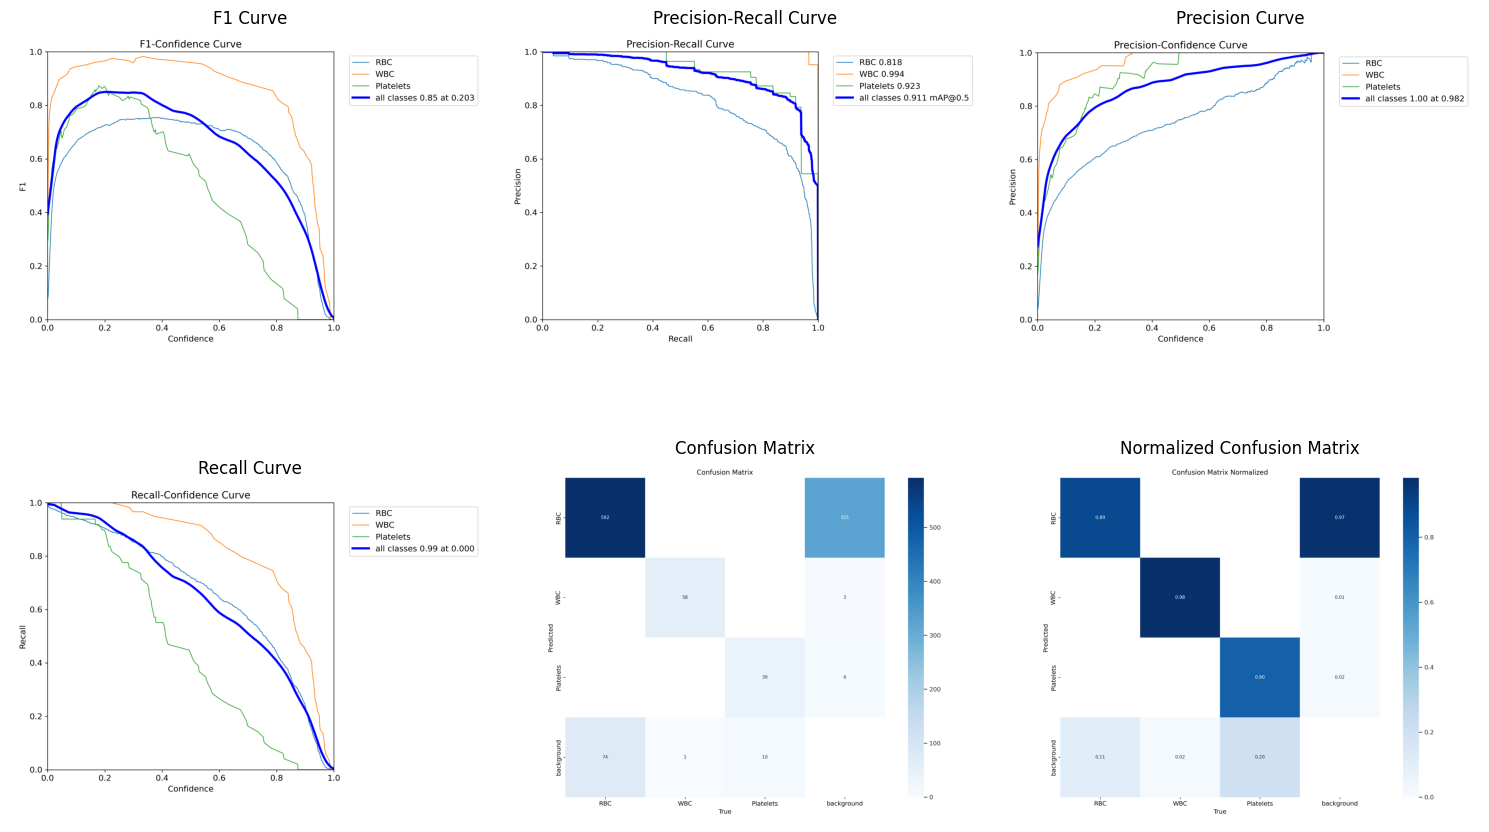

Training Arguments:
task: detect
mode: train
model: yolov10n.pt
data: dataset.yaml
epochs: 50
time: None
patience: 100
batch: 8
imgsz: 640
save: True
save_period: -1
cache: False
device: None
workers: 8
project: None
name: train
exist_ok: False
pretrained: True
optimizer: auto
verbose: True
seed: 0
deterministic: True
single_cls: False
rect: False
cos_lr: False
close_mosaic: 10
resume: False
amp: True
fraction: 1.0
profile: False
freeze: None
multi_scale: False
overlap_mask: True
mask_ratio: 4
dropout: 0.0
val: True
split: val
save_json: False
save_hybrid: False
conf: None
iou: 0.7
max_det: 300
half: False
dnn: False
plots: True
source: None
vid_stride: 1
stream_buffer: False
visualize: False
augment: False
agnostic_nms: False
classes: None
retina_masks: False
embed: None
show: False
save_frames: False
save_txt: False
save_conf: False
save_crop: False
show_labels: True
show_conf: True
show_boxes: True
line_width: None
format: torchscript
keras: False
optimize: False
int8: False
dynamic

In [8]:
# Visualize the metrics
import matplotlib.pyplot as plt
import yaml
import numpy as np
import seaborn as sns

def visualize_metrics(directory):
    """
    Visualizes metrics from object detection training.

    Args:
        directory (str): Path to the directory containing the metric files.
    """

    # Load metrics from files
    f1_curve = plt.imread(f"{directory}/F1_curve.png")
    pr_curve = plt.imread(f"{directory}/PR_curve.png")
    p_curve = plt.imread(f"{directory}/P_curve.png")
    r_curve = plt.imread(f"{directory}/R_curve.png")
    confusion_matrix = plt.imread(f"{directory}/confusion_matrix.png")
    confusion_matrix_normalized = plt.imread(f"{directory}/confusion_matrix_normalized.png")

    # Load arguments from YAML file
    with open(f"{directory}/args.yaml", 'r') as file:
        args = yaml.safe_load(file)

    # Display images
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(f1_curve)
    plt.title("F1 Curve")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(pr_curve)
    plt.title("Precision-Recall Curve")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(p_curve)
    plt.title("Precision Curve")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(r_curve)
    plt.title("Recall Curve")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(confusion_matrix)
    plt.title("Confusion Matrix")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(confusion_matrix_normalized)
    plt.title("Normalized Confusion Matrix")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print arguments from YAML
    print("Training Arguments:")
    for key, value in args.items():
        print(f"{key}: {value}")

# Example usage:
visualize_metrics('//content/runs/detect/train/')

In [9]:
#Inferencing
import cv2
from ultralytics import YOLO  # Assuming you're using YOLO

def perform_inference(image, model, class_names):
    """
    Performs object detection on the input image using the given model.

    Args:
        image: A NumPy array representing the input image.
        model: A trained YOLO model.
        class_names: A list of class names.

    Returns:
        image: The image with bounding boxes drawn on it.
        predictions: A list of dictionaries, where each dictionary represents
                     a detected object and contains 'class_name', 'confidence',
                     and 'box' (xyxy coordinates).
    """
    results = model(image)  # Perform inference

    predictions = []
    for box in results[0].boxes:
        xyxy = box.xyxy[0].numpy().astype(int)  # Bounding box coordinates
        conf = box.conf[0].numpy()  # Confidence score
        class_id = int(box.cls[0].numpy())  # Class ID
        class_name = class_names[class_id]  # Get class name

        # Draw bounding box and label on the image
        cv2.rectangle(image, xyxy[:2], xyxy[2:], (0, 255, 0), 2)
        label = f'{class_name}: {conf:.2f}'
        cv2.putText(image, label, (xyxy[0], xyxy[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        predictions.append({
            'class_name': class_name,
            'confidence': float(conf),  # Convert to float for Gradio
            'box': xyxy.tolist()  # Convert to list for Gradio
        })

    return image, predictions # Removed the duplicated block of code that was causing the IndentationError

In [10]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 7.3 MB/s eta 0:00:00


In [11]:
# Gradio
import torch
import cv2
import numpy as np
import gradio as gr
from ultralytics import YOLO

# Load the fine-tuned model
model = YOLO("/content/runs/detect/train/weights/best.pt")

def predict(image):
    # Convert PIL image to OpenCV format
    img = np.array(image)
    results = model(img)  # Run inference

    # Draw bounding boxes
    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = float(box.conf[0].cpu().numpy())  # Confidence score
            label = r.names[int(box.cls[0].cpu().numpy())]  # Class label

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"{label}: {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return img

# Gradio Interface
iface = gr.Interface(fn=predict, inputs=gr.Image(type="pil"), outputs=gr.Image(type="numpy"), title="BCCD Detection")
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://28c3cc9db8533f3b80.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
